
<img align="right" src="https://i.imgur.com/WeHlFmr.gif">

# Quantum gate synthesis



This notebook works through the process used to produce the gate synthesis results presented in *"Machine learning method for state preparation and gate synthesis on photonic quantum computers"*.

We use the continuous-variable (CV) quantum optical circuit package [Strawberry Fields](https://github.com/XanaduAI/strawberryfields), and in particular its TensorFlow backend, to perform quantum circuit optimization. By leveraging Tensorflow, we have access to a number of additional funtionalities, including GPU integration, automatic gradient computation, built-in optimization algorithms, and other machine learning tools.

## Variational quantum circuits

A key element of machine learning is optimization. We can use Tensorflow’s automatic differentiation tools to optimize the parameters of variational quantum circuits constructed using Strawberry Fields. In this approach, we fix a circuit architecture where the states, gates, and/or measurements may have learnable parameters $\vec{\theta}$ associated with them. We then define a loss function based on the output state of this circuit. In this case, we define a loss function such that the action of the variational quantum circuit is close to some specified target unitary. For more details on the TensorFlow backend in Strawberry Fields, please see the [Strawberry Fields documentation](http://strawberryfields.readthedocs.io/en/stable/tutorials/tutorial_machine_learning.html).

For arbitrary gate synthesis using optimization, we need to make use of a quantum circuit with a layer structure that is **universal** - that is, by 'stacking' the layers, we can guarantee that we can produce *any* CV state with at-most polynomial overhead. Therefore, the architecture we choose must consist of layers with each layer containing parameterized Gaussian *and* non-Gaussian gates. **The non-Gaussian gates provide both the nonlinearity and the universality of the model.** To this end, we employ the CV quantum neural network architecture described below:

![layer](https://i.imgur.com/NEsaVIX.png)

Here,


* $\mathcal{U}_i(\theta_i,\phi_i)$ is an N-mode linear optical interferometer composed of two-mode beamsplitters $BS(\theta,\phi)$ and single-mode rotation gates $R(\phi)=e^{i\phi\hat{n}}$,

* $\mathcal{D}(\alpha_i)$ are single mode displacements in the phase space by complex value $\alpha_i$,

* $\mathcal{S}(r_i, \phi_i)$ are single mode squeezing operations of magnitude $r_i$ and phase $\phi_i$, and

* $\Phi(\lambda_i)$ is a single mode non-Gaussian operation, in this case chosen to be the Kerr interaction $\mathcal{K}(\kappa_i)=e^{i\kappa_i\hat{n}^2}$ of strength $\kappa_i$.

<br/>

<div class="alert alert-success" style="border: 0px; border-left: 3px solid #119a68; color: black; background-color: #daf0e9">
<p style="color: #119a68;"><strong>Reference</strong></p>Killoran, N., Bromley, T. R., Arrazola, J. M., Schuld, M., Quesada, N., & Lloyd, S. (2018). "Continuous-variable quantum neural networks." <a href=https://arxiv.org/abs/1806.06871>arXiv:1806.06871</a>.
</div>

## Hyperparameters


First, we must define the **hyperparameters** of our layer structure:

* `cutoff`: the simulation Fock space truncation we will use in the optimization. The TensorFlow backend will perform numerical operations in this truncated Fock space when performing the optimization.


* `depth`: The number of layer ansatz in our variational quantum circuit. As a general rule, increasing the number of layers (and thus, the number of parameters we are optimizing over) increases the optimizers chance of finding a reasonable local minimum in the optimization landscape.


* `reps`: the number of steps in the optimization routine performing gradient descent

Some other optional hyperparameters include:

* The standard deviation of initial parameters. Note that we make a distinction between the standard deviation of *passive* parameters (those that preserve photon number when changed, such as phase parameters), and *active* parameters (those that introduce or remove energy from the system when changed).

In [12]:
# Cutoff dimension
cutoff = 10

# gate cutoff
gate_cutoff = 4

# Number of layers
depth = 25

# Number of steps in optimization routine performing gradient descent
reps = 1000

# Standard deviation of initial parameters
passive_sd = 0.1
active_sd = 0.001

Note that, unlike in state learning, we must also specify a *gate cutoff* $d$. This restricts the target unitary to its action on a $d$-dimensional subspace of the truncated Fock space, where $d\leq D$, where $D$ is the overall simulation Fock basis cutoff. As a result, we restrict the gate synthesis optimization to only $d$ input-output relations.

## The layer parameters $\vec{\theta}$

We use TensorFlow to create the variables corresponding to the gate parameters. Note that each variable has shape `[depth]`, with each individual element representing the gate parameter in layer $i$.

In [13]:
import tensorflow as tf

In [14]:
# squeeze gate
sq_r = tf.Variable(tf.random_normal(shape=[depth], stddev=active_sd))
sq_phi = tf.Variable(tf.random_normal(shape=[depth], stddev=passive_sd))

# displacement gate
d_r = tf.Variable(tf.random_normal(shape=[depth], stddev=active_sd))
d_phi = tf.Variable(tf.random_normal(shape=[depth], stddev=passive_sd))

# rotation gates
r1 = tf.Variable(tf.random_normal(shape=[depth], stddev=passive_sd))
r2 = tf.Variable(tf.random_normal(shape=[depth], stddev=passive_sd))

# kerr gate
kappa = tf.Variable(tf.random_normal(shape=[depth], stddev=active_sd))

For convenience, we store the TensorFlow variables representing the parameters in a list:

In [15]:
params = [r1, sq_r, sq_phi, r2, d_r, d_phi, kappa]

Now, we can create a function to define the $i$th layer, acting on qumode `q`. This allows us to simply call this function in a loop later on when we build our circuit.

In [16]:
# layer architecture
def layer(i, q):
    Rgate(r1[i]) | q
    Sgate(sq_r[i], sq_phi[i]) | q
    Rgate(r2[i]) | q
    Dgate(d_r[i], d_phi[i]) | q
    Kgate(kappa[i]) | q
    
    return q

## Constructing the circuit

Now that we have defined our gate parameters and our layer structure, we can import Strawberry Fields and construct our variational quantum circuit. Note that, to ensure the TensorFlow backend computes the circuit symbolically, we specify `eval=False`.

In [17]:
import strawberryfields as sf
from strawberryfields.ops import *

We must also specify the input states to the variational quantum circuit - these are the Fock state $\ket{i}$, $i=0,\dots,d$, allowing us to optimize the circuit parameters to learn the target unitary acting on all input Fock states within the $d$-dimensional subspace.

In [18]:
in_ket = np.zeros([gate_cutoff, cutoff])
np.fill_diagonal(in_ket, 1)

In [19]:
# Start SF engine
engine, q = sf.Engine(1)

# Apply circuit of layers with corresponding depth
with engine:
    Ket(in_ket) | q
    for k in range(depth):
        layer(k, q[0])

# Run engine
state = engine.run('tf', cutoff_dim=cutoff, eval=False, batch_size=gate_cutoff)
ket = state.ket()

Here, we use the `batch_size` argument to perform the optimization in parallel - each batch calculates the variational quantum circuit acting on a different input Fock state: $U(\vec{\theta})\ket{n}$. 

Note that the output state vector is an unevaluated tensor:

In [20]:
ket

<tf.Tensor 'ket_2:0' shape=(4, 10) dtype=complex64>

## Performing the optimization

$\newcommand{ket}[1]{\left|#1\right\rangle}$ With the Strawberry Fields TensorFlow backend calculating the resulting state of the circuit symbolically, we can use TensorFlow to optimize the gate parameters to minimize the cost function we specify. With gate synthesis, we minimize the overlaps in the Fock basis between the target and learnt unitaries via the following cost function:

$$C(\vec{\theta}) = \frac{1}{d}\sum_{i=0}^{d-1} \left| \langle i \mid V^\dagger U(\vec{\theta})\mid 0\rangle - 1\right|$$

where $V$ is the target unitary, $U(\vec{\theta})$ is the learnt unitary, and $d$ is the gate cutoff. Note that this is a generalization of state preparation to more than one input-output relation.

For our target unitary, lets use Strawberry Fields to generate a 4x4 random unitary:

In [29]:
from strawberryfields.utils import random_interferometer
target_unitary = np.identity(cutoff, dtype=np.complex128)
target_unitary[:gate_cutoff, :gate_cutoff] = random_interferometer(4)

This matches the gate cutoff of $d=4$ that we chose above when defining our hyperparameters.

Using this target state, we calculate the cost function we would like to minimize. We must use TensorFlow functions to manipulate this data, as were are working with symbolic variables!

In [31]:
in_state = np.arange(gate_cutoff)

# extract action of the target unitary acting on
# the allowed input fock states.
target_kets = np.array([target_unitary[:, i] for i in in_state])
target_kets = tf.constant(target_kets, dtype=tf.complex64)

# overlaps
overlaps = tf.real(tf.einsum('bi,bi->b', tf.conj(target_kets), ket))
mean_overlap = tf.reduce_mean(overlaps)

# cost
cost = tf.reduce_sum(tf.abs(overlaps - 1))

Now that the cost function is defined, we can define and run the optimization. Below, we choose the Adam optimizer that is built into TensorFlow.

In [32]:
# Using Adam algorithm for optimization
optimiser = tf.train.AdamOptimizer()
min_cost = optimiser.minimize(cost)

# Begin Tensorflow session
session = tf.Session()
session.run(tf.global_variables_initializer())

We then loop over all repetitions, storing the best predicted fidelity value. 

In [33]:
overlap_progress = []
cost_progress = []

# Run optimization
for i in range(reps):

    # one repitition of the optimization
    _, cost_val, overlaps_val, ket_val, params_val = session.run(
        [min_cost, cost, overlaps, ket, params])
    
    # calculate the mean overlap
    # This gives us an idea of how the optimization is progressing
    mean_overlap_val = np.mean(overlaps_val)

    # store cost at each step
    cost_progress.append(cost_val)
    overlap_progress.append(overlaps_val)

    # Prints progress at every 100 reps
    if i % 100 == 0:
        # print progress
        print("Rep: {} Cost: {:.4f} Mean overlap: {:.4f}".format(i, cost_val, mean_overlap_val))

Rep: 0 Cost: 3.6192 Mean overlap: 0.0952
Rep: 100 Cost: 1.5429 Mean overlap: 0.6143
Rep: 200 Cost: 0.9477 Mean overlap: 0.7631
Rep: 300 Cost: 0.6980 Mean overlap: 0.8255
Rep: 400 Cost: 0.5446 Mean overlap: 0.8638
Rep: 500 Cost: 0.3473 Mean overlap: 0.9132
Rep: 600 Cost: 0.2198 Mean overlap: 0.9451
Rep: 700 Cost: 0.1746 Mean overlap: 0.9564
Rep: 800 Cost: 0.1542 Mean overlap: 0.9614
Rep: 900 Cost: 0.1287 Mean overlap: 0.9678


## Results and visualisation

Plotting the cost vs. optimization step:

In [34]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = ['Computer Modern Roman']
plt.style.use('default')

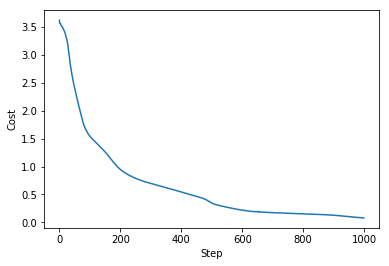

In [37]:
plt.plot(cost_progress)
plt.ylabel('Cost')
plt.xlabel('Step');

We can use matrix plots to plot the real and imaginary components of the target and learnt unitary.

In [40]:
learnt_unitary = ket_val.T[:gate_cutoff, :gate_cutoff]
target_unitary = target_unitary[:gate_cutoff, :gate_cutoff]

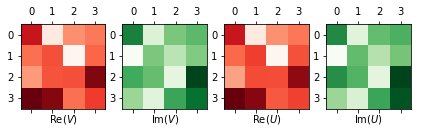

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(7, 4))
ax[0].matshow(target_unitary.real, cmap=plt.get_cmap('Reds'))
ax[1].matshow(target_unitary.imag, cmap=plt.get_cmap('Greens'))
ax[2].matshow(learnt_unitary.real, cmap=plt.get_cmap('Reds'))
ax[3].matshow(learnt_unitary.imag, cmap=plt.get_cmap('Greens'))

ax[0].set_xlabel(r'$\mathrm{Re}(V)$')
ax[1].set_xlabel(r'$\mathrm{Im}(V)$')
ax[2].set_xlabel(r'$\mathrm{Re}(U)$')
ax[3].set_xlabel(r'$\mathrm{Im}(U)$');

## Process fidelity

The process fidelity between the two unitaries is defined by

$$F_e  = \left| \left\langle \Psi(V) \mid \Psi(U)\right\rangle\right|^2$$

where:

* $\left|\Psi(V)\right\rangle$ is the action of $V$ on one
half of a maximally entangled state $\left|\phi\right\rangle$:

$$\left|\Psi(V)\right\rangle = (I\otimes V)\left|\phi\right\rangle,$$


* $V$ is the target unitary,
* $U$ the learnt unitary.

In [44]:
I = np.identity(gate_cutoff)
phi = I.flatten()/np.sqrt(gate_cutoff)
psiV = np.kron(I, target_unitary) @ phi
psiU = np.kron(I, learnt_unitary) @ phi

In [45]:
np.abs(np.vdot(psiV, psiU))**2

0.96021542096280033

Therefore, after 1000 repetitions, the learnt unitary synthesized via a variational quantum circuit, has a process fidelity of 96.02% to the target unitary.